In [1]:
!pip uninstall -y flash-attn flash-attn-2 flash_attn flash_attn_2


DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/opt_einsum-3.4.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/igraph-0.11.8-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_thunder-0.2.0.dev0-py3.12.egg is deprecated. pip 25.1 wil

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import librosa
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch.nn as nn
from torch.optim import Adam
from torch.nn.functional import cross_entropy


/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-06 07:41:30.674410: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 07:41:30.686189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746517290.699700 2851760 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746517290.703553 2851760 cuda_blas.cc:1407] Unable to register 

In [3]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [4]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)
wav2vec_model.eval()


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [15]:
class FSCWav2VecDataset(Dataset):
    def __init__(self, csv_path, wav_base_path, processor, model, device, label2idx):
        self.df = pd.read_csv(csv_path)
        self.wav_base_path = wav_base_path
        self.processor = processor
        self.model = model
        self.device = device
        self.label2idx = label2idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        wav_rel_path = row['path'] if 'path' in row else row['wav_path']
        if wav_rel_path.startswith('wavs/speakers/'):
            wav_rel_path = wav_rel_path[len('wavs/speakers/'):]
        wav_path = os.path.join(self.wav_base_path, wav_rel_path)
        label = row['intent']  # <--- Use intent
        audio, sr = librosa.load(wav_path, sr=16000)
        inputs = self.processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        with torch.no_grad():
            features = self.model(inputs.input_values.to(self.device)).last_hidden_state.squeeze(0)
        return features.cpu(), self.label2idx[label]


In [16]:
def collate_fn(batch):
    features, labels = zip(*batch)
    lengths = [f.shape[0] for f in features]
    max_len = max(lengths)
    feat_dim = features[0].shape[1]
    batch_feats = torch.zeros(len(features), max_len, feat_dim)
    for i, f in enumerate(features):
        batch_feats[i, :f.shape[0], :] = f
    return batch_feats, torch.tensor(labels), torch.tensor(lengths)


In [21]:
train_csv = 'NLP/FCS/data/train_data.csv'
val_csv = 'NLP/FCS/data/valid_data.csv'
test_csv = 'NLP/FCS/data/test_data.csv'
wav_base = 'NLP/FCS/wavs/speakers'

def add_intent_column(csv_path):
    df = pd.read_csv(csv_path)
    df['intent'] = df['action'].fillna('') + '_' + df['object'].fillna('') + '_' + df['location'].fillna('')
    df['intent'] = df['intent'].str.strip('_')
    df.to_csv(csv_path, index=False)
    return df

train_df = add_intent_column(train_csv)
val_df = add_intent_column(val_csv)
test_df = add_intent_column(test_csv)

# For training data
train_df = pd.read_csv(train_csv)
train_df['intent'] = train_df['action'].fillna('') + "_" + \
                     train_df['object'].fillna('') + "_" + \
                     train_df['location'].fillna('')

val_df = pd.read_csv(val_csv)
val_df['intent'] = val_df['action'].fillna('') + "_" + \
                   val_df['object'].fillna('') + "_" + \
                   val_df['location'].fillna('')


all_labels = train_df['intent'].unique().tolist()
label2idx = {lbl: i for i, lbl in enumerate(all_labels)}
idx2label = {i: lbl for lbl, i in label2idx.items()}
num_classes = len(label2idx)



In [22]:
train_ds = FSCWav2VecDataset(train_csv, wav_base, processor, wav2vec_model, device, label2idx)
val_ds = FSCWav2VecDataset(val_csv, wav_base, processor, wav2vec_model, device, label2idx)
test_ds = FSCWav2VecDataset(test_csv, wav_base, processor, wav2vec_model, device, label2idx)

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_dl = DataLoader(test_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)


In [23]:
class CNN_GRU_Model(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Conv1d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128)
        )
        self.gru = nn.GRU(128, 128, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(128*2, num_classes)

    def forward(self, x, lengths):
        # x: [batch, time, feat]
        x = x.transpose(1,2)  # [batch, feat, time]
        x = self.cnn(x)
        x = x.transpose(1,2)  # [batch, time, feat]
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.gru(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        last_outputs = out[torch.arange(out.size(0)), lengths-1]
        logits = self.classifier(last_outputs)
        return logits


In [24]:
model = CNN_GRU_Model(input_dim=768, num_classes=num_classes).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
epochs = 30  
patience = 5  
best_val_acc = 0
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb, lengths in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}"):
        xb, yb, lengths = xb.to(device), yb.to(device), lengths.to(device)
        optimizer.zero_grad()
        logits = model(xb, lengths)
        loss = cross_entropy(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {running_loss/len(train_dl):.4f}")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb, lengths in val_dl:
            xb, yb, lengths = xb.to(device), yb.to(device), lengths.to(device)
            logits = model(xb, lengths)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    print(f"Validation accuracy: {val_acc:.4f}")

    # Early stopping and best model saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_cnn_gru_model.pt")
        print("Best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/30: 100%|██████████| 2892/2892 [02:18<00:00, 20.87it/s]


Epoch 1 loss: 1.3379
Validation accuracy: 0.7434
Best model saved.


Epoch 2/30: 100%|██████████| 2892/2892 [02:17<00:00, 20.96it/s]


Epoch 2 loss: 0.3427
Validation accuracy: 0.8518
Best model saved.


Epoch 3/30: 100%|██████████| 2892/2892 [02:16<00:00, 21.16it/s]


Epoch 3 loss: 0.1861
Validation accuracy: 0.8743
Best model saved.


Epoch 4/30: 100%|██████████| 2892/2892 [02:18<00:00, 20.89it/s]


Epoch 4 loss: 0.1434
Validation accuracy: 0.8922
Best model saved.


Epoch 5/30: 100%|██████████| 2892/2892 [02:17<00:00, 21.11it/s]


Epoch 5 loss: 0.1161
Validation accuracy: 0.8935
Best model saved.


Epoch 6/30: 100%|██████████| 2892/2892 [02:17<00:00, 20.98it/s]


Epoch 6 loss: 0.1005
Validation accuracy: 0.8999
Best model saved.


Epoch 7/30: 100%|██████████| 2892/2892 [02:17<00:00, 21.05it/s]


Epoch 7 loss: 0.0874
Validation accuracy: 0.8961


Epoch 8/30: 100%|██████████| 2892/2892 [02:17<00:00, 21.02it/s]


Epoch 8 loss: 0.0768
Validation accuracy: 0.9038
Best model saved.


Epoch 9/30: 100%|██████████| 2892/2892 [02:17<00:00, 21.10it/s]


Epoch 9 loss: 0.0663
Validation accuracy: 0.8951


Epoch 10/30: 100%|██████████| 2892/2892 [02:17<00:00, 21.00it/s]


Epoch 10 loss: 0.0615
Validation accuracy: 0.9035


Epoch 11/30: 100%|██████████| 2892/2892 [02:17<00:00, 21.09it/s]


Epoch 11 loss: 0.0547
Validation accuracy: 0.9073
Best model saved.


Epoch 12/30: 100%|██████████| 2892/2892 [02:19<00:00, 20.73it/s]


Epoch 12 loss: 0.0495
Validation accuracy: 0.8967


Epoch 13/30: 100%|██████████| 2892/2892 [02:17<00:00, 21.06it/s]


Epoch 13 loss: 0.0453
Validation accuracy: 0.9051


Epoch 14/30: 100%|██████████| 2892/2892 [02:24<00:00, 20.08it/s]


Epoch 14 loss: 0.0467
Validation accuracy: 0.9070


Epoch 15/30: 100%|██████████| 2892/2892 [02:24<00:00, 20.06it/s]


Epoch 15 loss: 0.0428
Validation accuracy: 0.9047


Epoch 16/30: 100%|██████████| 2892/2892 [02:22<00:00, 20.30it/s]


Epoch 16 loss: 0.0441
Validation accuracy: 0.9086
Best model saved.


Epoch 17/30: 100%|██████████| 2892/2892 [02:21<00:00, 20.40it/s]


Epoch 17 loss: 0.0314
Validation accuracy: 0.8967


Epoch 18/30: 100%|██████████| 2892/2892 [02:21<00:00, 20.42it/s]


Epoch 18 loss: 0.0410
Validation accuracy: 0.8993


Epoch 19/30: 100%|██████████| 2892/2892 [02:23<00:00, 20.17it/s]


Epoch 19 loss: 0.0344
Validation accuracy: 0.8983


Epoch 20/30: 100%|██████████| 2892/2892 [02:20<00:00, 20.54it/s]


Epoch 20 loss: 0.0375
Validation accuracy: 0.9067


Epoch 21/30: 100%|██████████| 2892/2892 [02:19<00:00, 20.71it/s]


Epoch 21 loss: 0.0297
Validation accuracy: 0.9025
Early stopping triggered.


In [25]:
from sklearn.metrics import classification_report

model.load_state_dict(torch.load("best_cnn_gru_model.pt"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb, lengths in test_dl:
        xb, yb, lengths = xb.to(device), yb.to(device), lengths.to(device)
        logits = model(xb, lengths)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(yb.cpu())

# Concatenate all batches
import torch
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Print test accuracy
test_acc = (all_preds == all_labels).mean()
print(f"Test accuracy: {test_acc:.4f}")


Test accuracy: 0.9910


In [26]:
# Print classification report
print(classification_report(all_labels, all_preds, target_names=[idx2label[i] for i in range(num_classes)]))


                              precision    recall  f1-score   support

   change language_none_none       0.99      1.00      1.00       160
         activate_music_none       0.98      0.98      0.98       121
        activate_lights_none       0.99      0.98      0.98        87
      deactivate_lights_none       1.00      0.99      0.99        85
        increase_volume_none       0.99      1.00      0.99       396
        decrease_volume_none       0.98      0.99      0.99       345
          increase_heat_none       0.99      0.97      0.98       172
          decrease_heat_none       0.98      0.98      0.98       176
       deactivate_music_none       1.00      0.98      0.99       105
          activate_lamp_none       1.00      1.00      1.00        70
        deactivate_lamp_none       1.00      1.00      1.00        74
     activate_lights_kitchen       0.99      0.99      0.99       133
     activate_lights_bedroom       1.00      0.98      0.99        97
    activate_lights

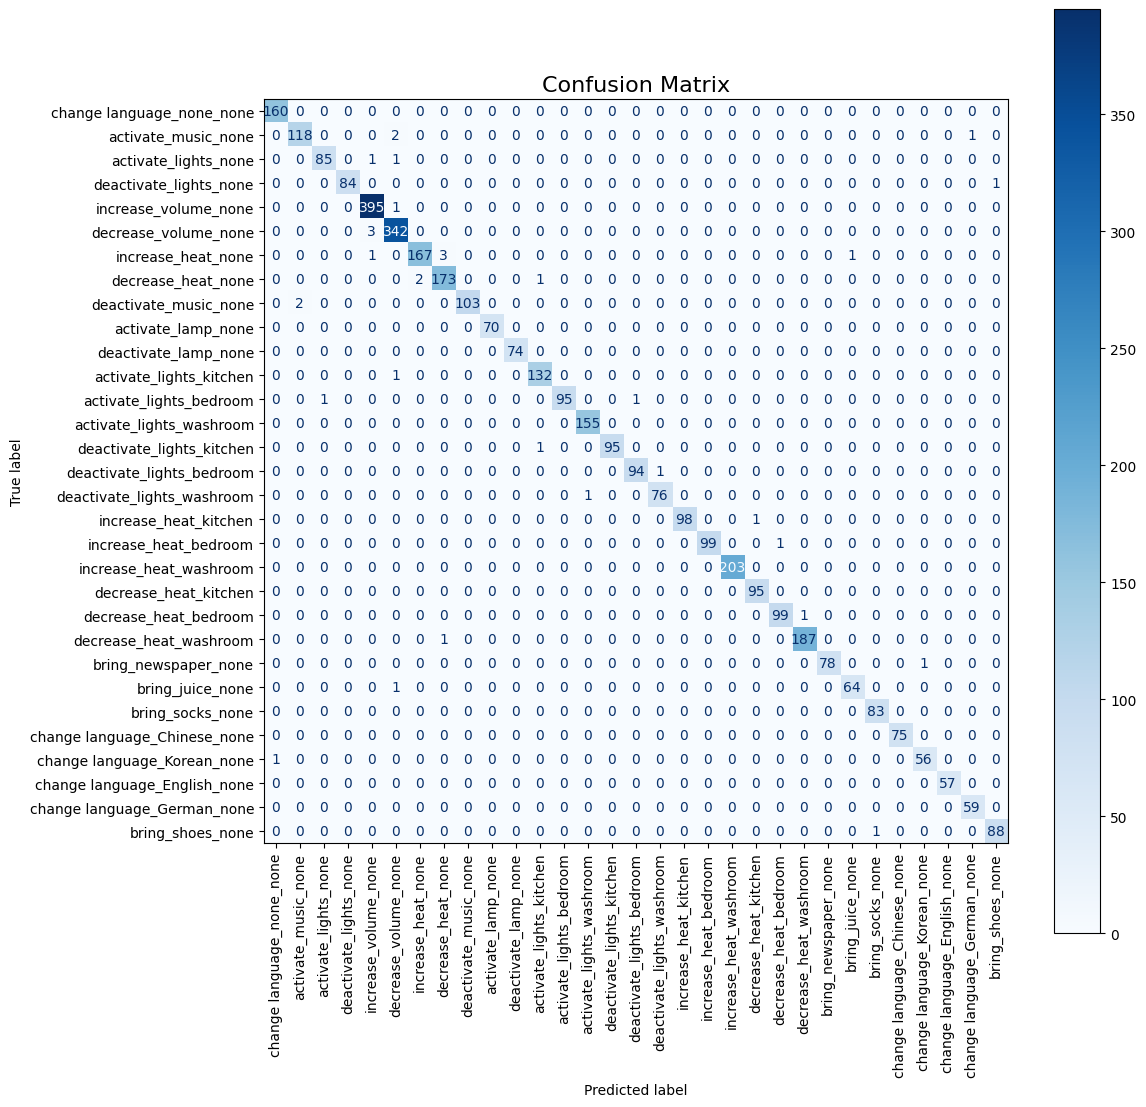

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Set figure size and font size for better visibility
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2label[i] for i in range(num_classes)])
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax, colorbar=True)

# Adjust font size for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Confusion Matrix", fontsize=16)
plt.show()